<a href="https://colab.research.google.com/github/froghop/2DBreastDensityConvNet/blob/main/2D_ConvNet_Breast_Density.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**2D ConvNet for Breast Density**

The followinng notebook analyzes mammograms to determine a breast density classification of dense or not dense.

Data can be found at: https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM



---



---



In [1]:
#Library Download
!pip install numpy tensorflow keras sklearn pandas pydicom kornia opencv-python scikit-image nbdev --quiet

     |████████████████████████████████| 2.0 MB 29.5 MB/s 
     |████████████████████████████████| 401 kB 36.2 MB/s 
     |████████████████████████████████| 46 kB 2.1 MB/s 
     |████████████████████████████████| 56 kB 1.9 MB/s 
     |████████████████████████████████| 51 kB 208 kB/s 


In [2]:
import pandas as pd
import tensorflow as tf
import os
import skimage as sk
import numpy as np
import cv2
import pydicom as pdm
import matplotlib.pyplot as plt

from pydicom import dcmread
from skimage.transform import resize
from skimage.io import imread
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# General Data Loading

In [4]:
df_test_path = 'gdrive/My Drive/UCSF/mass_case_description_test_set.csv' 
df_train_path = 'gdrive/My Drive/UCSF/mass_case_description_train_set.csv' 

In [5]:
df_test = pd.read_csv(df_test_path)#, index_col="patient_id")
df_train = pd.read_csv(df_train_path)#, index_col="patient_id")

# Data Exploration

The following code explores the format of DICOM files and the contents of the CSV file. It is not necessary for the overall functionality of the model.

In [ ]:
type(df_test)

pandas.core.frame.DataFrame

In [ ]:
df_train[0:5]

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
df_test[0:5]

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [6]:
ex1 = df_test.iloc[0]

In [ ]:
ex1['image file path']

'Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100.1.2.416403281812750683720028031170500130104/1.3.6.1.4.1.9590.100.1.2.245063149211255120613007755642780114172/000000.dcm'

In [ ]:
df_train.describe()

,breast_density,abnormality id,assessment,subtlety
count,1318.000000,1318.000000,1318.000000,1318.000000
mean,2.203338,1.116085,3.504552,3.965857
std,0.873774,0.467013,1.414609,1.102032
min,1.000000,1.000000,0.000000,0.000000
25%,2.000000,1.000000,3.000000,3.000000
50%,2.000000,1.000000,4.000000,4.000000
75%,3.000000,1.000000,4.000000,5.000000
max,4.000000,6.000000,5.000000,5.000000


The following function is a remnant of an earlier version of the notebook. It neglects any image identifiers for the purposes of matching breast densities to images, (and, not to mention, adds a layer of inefficiency by solely collecting images) but was useful for understanding what the model data looked like. 

In [ ]:
#ignore

root_path = 'gdrive/My Drive/UCSF/CBIS-DDSM/' 
dcm_png_items = []

def dicom_load(path):
  for dirName, subDir, filels in os.walk(path):
    for fileName in filels:
      filepath = dirName + os.sep + fileName
      if ".dcm" in fileName:
        #want to append this to a greater directory
        dcm_read_file = pdm.dcmread(filepath)
        ##dcm_items.append(dcm_read_file)
        dcm_png_items.append(dcm_read_file)
        filepaths.append(filepath)
      else: 
        ##png_items.append(filepath)
        dcm_png_items.append(filepath)
      filepaths.append(filepath)

In [ ]:
dicom_load(root_path)

In [ ]:
dcm_png_items[0]

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 194
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Secondary Capture Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.9590.100.1.2.39500220012318751030553662833275533580
(0002, 0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 1.2.40.0.13.1.1.1
(0002, 0013) Implementation Version Name         SH: 'dcm4che-1.4.35'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0016) SOP Class UID                       UI: Secondary Capture Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.3.6.1.4.1.9590.100.1.2.39500220012318751030553662833275533580
(0008, 0020) Study Date                          DA: ''
(0008, 0023) Content Date       

# DICOM / PNG file Loading

***Problem Statement:*** Write a function that can load DICOM or PNG file and then convert them to user specified image size (ex: 299 x 299 or 229x229) numpy files. The DICOM files may be compressed or uncompresed. This function needs to be user-friendly and should be able to stand on its own. The image re-sizing can be done by SKlearn or other library.

**Resources:** 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3354356/

In [6]:
root_path = 'gdrive/My Drive/UCSF/CBIS-DDSM/' 

In [7]:
"""
Dictionary for use in `load_and_resize` and `match_img_to_density`.
key = counter
val = [fileName, image]
"""
dic = {}

**dirName** - represented in 
the format "Calc-Test_P_ ###..."

**subdir** - represented as 'date-DDSM..."

**subsubdir** - represented as "1.0000...-" + description of image location

**filels** - represented as "1-#.dcm" where # increases to represent the ith file in the folder

In [9]:
def load_and_resize(path, x, y):
  """
  Reads the images, resizes them, and saves them along with their pertinent 
  identifiers into dic. 
  @param path: the root path to begin file extraction from
  @param x: desired x-cord
  @param y: desired y-cord

  """
  counter = 1
  for dirName, subDir, filels in os.walk(path):
    for fileName in filels:
      filepath = dirName + os.sep + fileName
      #print(str(counter) + " : " + filepath[31:])
      if ".png" in fileName:
        imgpng = cv2.imread(filepath)

        imgpng_resized = resize(imgpng, (x,y))

        dic[counter] = [filepath[31:], imgpng_resized]

      else:
        dcm_file = pdm.dcmread(filepath, force=True)
        #if file compressed
        if ".dcm" not in fileName:
          print("not .dcm" + fileName)
          dcm_file = dcm_file.decompress()

        resized_dcm_ndarray = resize(dcm_file.pixel_array, (x,y))

        dic[counter] = [filepath[31:], resized_dcm_ndarray]
      counter +=1
      
  print("Loading and resizing successful.")

In [10]:
load_and_resize(root_path, 229, 229)

Loading and resizing successful.


In [11]:
train_data, train_labels = [], []
test_data, test_labels = [], []

In [12]:
def match_img_to_density(dataframe_train, dataframe_test):
  """
  Matches the images to their according breast density classifcation per the CSV file.
  Enters this information into respective lists for train and test, data and labels.
  @param dataframe_train: dataframe (from csv) with training data
  @param dataframe_test: dataframe (from csv) with test data
  """
  for p_id in dic:
    ls = dic[p_id]
    filepath = ls[0]
    fn = filepath.split('/')[0]
    img = ls[1]
    if 'Test' in fn:
      data = dataframe_test.loc[dataframe_test['cropped image file path'].str.contains(fn)]
      
      if data['breast_density'].iloc[0] <=2:
        density = 0
      else:
        density = 1
      #density = (0 if data['breast_density'].iloc[0] <= 2 else 1)
      test_data.append(img)
      test_labels.append(density)
    else:
      data = dataframe_train.loc[dataframe_train['cropped image file path'].str.contains(fn)]
      
      if data['breast_density'].iloc[0] <=2:
        density = 0
      else:
        density = 1
      #density = (0 if data['breast_density'].iloc[0] <= 2 else 1)
      train_data.append(img)
      train_labels.append(density)

  print("Matching successful.")

In [13]:
match_img_to_density(df_train, df_test)

Matching successful.


The following blocks convert the data and labels into numpy arrays and then tensors, and finally into a dataset.

In [14]:
train_data = np.asarray(train_data)
train_data = tf.convert_to_tensor(train_data) 

train_labels = np.asarray(train_labels)
train2_labels = tf.convert_to_tensor(train_labels) #changed to 2

train_dataset = tf.data.Dataset.from_tensor_slices((train_data, train_labels))

In [15]:
test_data = np.asarray(test_data)
test_data = tf.convert_to_tensor(test_data)

test_labels = np.asarray(test_labels)
test2_labels = tf.convert_to_tensor(test_labels)

test_dataset = tf.data.Dataset.from_tensor_slices((test_data, test_labels))

The following blocks are for the ResNet model specifically. They add a dimension to the data to represent a single color channel, and then, as done in the previous blocks, the data and labels are converted ultimately into tensors and then a dataset. 

In [16]:
train2_data = []
train2_labels = []

for _ in train_data:
  train2_data.append(tf.expand_dims(_, -1))

for _ in train_labels:
  train2_labels.append(tf.expand_dims(_, 0))

train2_data = tf.convert_to_tensor(train2_data)
train2_labels = tf.convert_to_tensor(train2_labels)

train2_dataset = tf.data.Dataset.from_tensor_slices((train2_data, train2_labels))

In [17]:
test2_data = []
test2_labels = []

for _ in test_data:
  test2_data.append(tf.expand_dims(_, -1))

for _ in test_labels:
  test2_labels.append(tf.expand_dims(_, 0))

test2_data = tf.convert_to_tensor(test2_data)
test2_labels = tf.convert_to_tensor(test2_labels)

test2_dataset = tf.data.Dataset.from_tensor_slices((test2_data, test2_labels))

The following function attempts to simplify these code blocks utilizing functions.

In [ ]:
def main_dataset_load(root_path, x, y, df_train, df_test):
  load_and_resize(root_path, x, y)

  new_df_train, new_df_test = match_img_to_density(df_train, df_test)

  train_dataset = data_to_tensor_dataset(new_df_test)
  test_dataset = data_to_tensor_dataset(new_df_train)
  
  return (train_dataset, test_dataset)

In [ ]:
train_dataset, test_dataset = main_dataset_load(root_path, 229, 229, df_train, df_test)

# numpyZ

***Problem Statement:*** Combine the numpy file with breast density information (binary) to create numpyZ files.

The remaining code in the notebook does not utilize these specific usages of npz fies, so the npy and npz files within `create_npy_npz()` are not rooted in a directory, although the functionality could be implemented.

In [18]:
def create_npy_npz():
  f_train_df = pd.DataFrame({'Data': train_data, 'Labels': train_labels})
  f_test_df = pd.DataFrame({'Data': test_data, 'Labels': test_labels})

  with open('train_df.npy', 'w') as fp_train:
    pass
  with open('test_df.npy', 'w') as fp_test:
    pass

  np.save(fp_train, f_train_df)
  np.save(fp_test, f_test_df)


  with open('train_df.npz', 'w') as fp_train_z:
    pass
  with open('test_df.npz', 'w') as fp_test_z:
    pass

  np.savez(fp_train_z, fp_train)
  np.savez(fp_test_z, fp_test)

# Basic ResNet Architecture

***Problem Statement:*** Create a basic ResNet architecture to train on breast denseness (we will make this a 2D classification program with 2 classes). There are four breast densities: ABCD, but for this project, set Density A and B as "not dense". Density C and D as "dense" to make this a 2-class classification program. Please note that getting high  accuracy is not the goal at this point, but just writing a neural network algorithm that runs without error is fine.

**Resources:**
https://towardsdatascience.com/understand-and-implement-resnet-50-with-tensorflow-2-0-1190b9b52691

https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035

https://www.analyticsvidhya.com/blog/2021/08/how-to-code-your-resnet-from-scratch-in-tensorflow/

https://keras.io/examples/vision/image_classification_from_scratch/


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D, Activation, BatchNormalization, GlobalAvgPool2D, MaxPool2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [20]:
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ReduceLROnPlateau

## i. ResNet

The following code is modified from code written by Géron Aurélien in the book ***Hands-on Machine learning with Scikit-Learn and Tensorflow: Concepts, Tools, and Techniques to Build Intelligent Systems*** (pg. 479, 2019).

In [122]:
from functools import partial
DefaultConv2D = partial(Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

In [123]:
rmodel = tf.keras.Sequential()
rmodel.add(Conv2D(64,3, strides=2, input_shape=[229,229,1], padding="same", use_bias=False))#64,7
rmodel.add(BatchNormalization())
rmodel.add(Activation("relu"))
rmodel.add(MaxPool2D(pool_size=3, strides=2, padding="same"))

prev_filters = 64

#adding RU
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    rmodel.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters

rmodel.add(GlobalAvgPool2D())
rmodel.add(Flatten())
rmodel.add(Dense(1, activation='sigmoid')) #changed softmax to sigmoid

In [124]:
rmodel.compile(optimizer=tf.keras.optimizers.Adam(), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

In [166]:
rmodel.fit(train2_data, train2_labels, epochs=15)

Epoch 1/15
3/3 [==============================] - 43s 12s/step - loss: 0.6932 - accuracy: 0.5890
Epoch 2/15
3/3 [==============================] - 43s 12s/step - loss: 0.6636 - accuracy: 0.6164
Epoch 3/15
3/3 [==============================] - 43s 12s/step - loss: 0.6526 - accuracy: 0.5890
Epoch 4/15
3/3 [==============================] - 43s 12s/step - loss: 0.6625 - accuracy: 0.6027
Epoch 5/15
3/3 [==============================] - 43s 12s/step - loss: 0.6165 - accuracy: 0.6849
Epoch 6/15
3/3 [==============================] - 43s 12s/step - loss: 0.6433 - accuracy: 0.6438
Epoch 7/15
3/3 [==============================] - 43s 12s/step - loss: 0.6390 - accuracy: 0.6438
Epoch 8/15
3/3 [==============================] - 43s 12s/step - loss: 0.6114 - accuracy: 0.6849
Epoch 9/15
3/3 [==============================] - 43s 12s/step - loss: 0.5875 - accuracy: 0.6849
Epoch 10/15
3/3 [==============================] - 43s 12s/step - loss: 0.5756 - accuracy: 0.7123
Epoch 11/15
3/3 [============

Perfect number of epochs seems to be 12.

In [167]:
rmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_72 (Conv2D)          (None, 115, 115, 64)      576       
                                                                 
 batch_normalization_72 (Bat  (None, 115, 115, 64)     256       
 chNormalization)                                                
                                                                 
 activation_2 (Activation)   (None, 115, 115, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 58, 58, 64)       0         
 2D)                                                             
                                                                 
 residual_unit_32 (ResidualU  (None, 58, 58, 64)       74240     
 nit)                                                            
                                                      

## ii. Plain Dense Network

Epoch 1/1000
5/5 [==============================] - 1s 35ms/step - loss: 3.9701 - accuracy: 0.5205
Epoch 2/1000
5/5 [==============================] - 0s 35ms/step - loss: 1.3308 - accuracy: 0.6712
Epoch 3/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.4820 - accuracy: 0.7397
Epoch 4/1000
5/5 [==============================] - 0s 37ms/step - loss: 0.5299 - accuracy: 0.6712
Epoch 5/1000
5/5 [==============================] - 0s 38ms/step - loss: 0.3930 - accuracy: 0.7808
Epoch 6/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.3972 - accuracy: 0.7945
Epoch 7/1000
5/5 [==============================] - 0s 35ms/step - loss: 0.3816 - accuracy: 0.7945
Epoch 8/1000
5/5 [==============================] - 0s 39ms/step - loss: 0.3702 - accuracy: 0.8082
Epoch 9/1000
5/5 [==============================] - 0s 38ms/step - loss: 0.3793 - accuracy: 0.8082
Epoch 10/1000
5/5 [==============================] - 0s 36ms/step - loss: 0.3885 - accuracy: 0.7945
Epoch 11/

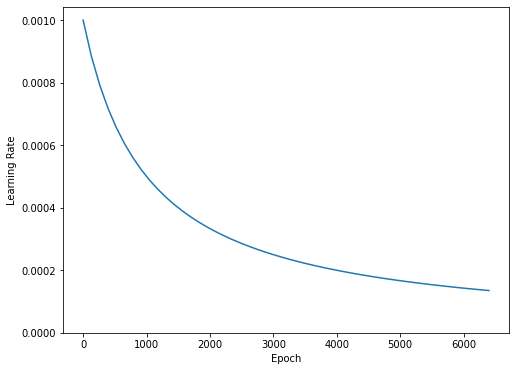

In [ ]:
#binary classification
batch_size=16
steps_per_epoch = 250/batch_size

lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay( 
    0.001, 
    decay_steps=steps_per_epoch*1000, 
    decay_rate=1,
    staircase=False)


step = np.linspace(0,100000)
lr = lr_schedule(step) 
plt.figure(figsize = (8,6)) 
plt.plot(step/steps_per_epoch, lr) 
plt.ylim([0,max(plt.ylim())]) 
plt.xlabel('Epoch')
_ = plt.ylabel('Learning Rate')

bmodel = tf.keras.Sequential([ 
                             tf.keras.layers.Flatten(input_shape=(229, 229)),
                             tf.keras.layers.Dense(128, activation='relu'), 
                             tf.keras.layers.Dense(64, activation='tanh'), 
                             tf.keras.layers.Dense(32, activation='sigmoid'), 
                             tf.keras.layers.Dense(1)
])


bmodel.compile(optimizer=tf.keras.optimizers.Adam(lr_schedule), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)


bmodel.fit(x=train_data, y=train_labels, epochs=1000, batch_size=16, callbacks=[callback])


# Algorithm Prediction

***Problem Statement:*** Perform prediction with the algorithm on the testing set and provide your predictions on the test set (it need not be good at this point).

In [86]:
# Function for making model predictions binary.
# `preds`: numpy.ndarray of model predictions

def clean_preds(preds):
  for _ in range(len(preds)):
    if preds[_] < 0.5:
      preds[_] = 0
    else:
      preds[_] = 1

## i) ResNet Predictions

In [168]:
rpreds = rmodel.predict(test2_data)

In [169]:
clean_preds(rpreds)

## ii) Plain Dense Network (bmodel) Predictions

In [ ]:
#Prediction based on the bmodel
bpreds = bmodel.predict(test_data)

In [ ]:
bpreds

array([[ 0.37848145],
       [-0.10918489],
       [ 0.39612377],
       [ 0.73552257],
       [ 0.4809768 ],
       [ 0.39612377],
       [ 0.4882709 ],
       [ 0.39612377],
       [-0.04600895],
       [ 0.48298123],
       [ 0.39612377],
       [ 0.37464425],
       [ 0.38317293],
       [ 0.41721788],
       [ 0.00283003],
       [ 1.6225054 ],
       [ 0.39612377],
       [ 0.47806886],
       [ 0.39612377],
       [ 1.043559  ],
       [ 0.39612377],
       [-0.2224859 ],
       [ 0.27550447],
       [ 0.3677779 ],
       [ 0.39612377],
       [ 0.38684654],
       [ 0.39612377],
       [ 0.6344951 ],
       [ 0.48097005],
       [ 0.39612377],
       [ 0.63636976],
       [ 0.39612392],
       [ 0.8815041 ],
       [ 0.37046602],
       [ 0.39612377],
       [ 1.1999772 ],
       [ 0.39612377],
       [-0.306533  ],
       [ 0.39612377],
       [ 1.1690291 ],
       [ 0.39612377],
       [ 0.2864031 ],
       [ 0.55502135],
       [ 0.40137854],
       [ 0.39612377],
       [ 0

In [ ]:
clean_preds(bpreds)

## iii) Keras Accuracy Metrics

Keras Accuracy Metrics for the Plain Dense Network Model.

In [ ]:
acc = tf.keras.metrics.Accuracy(name="accuracy")

In [ ]:
acc.update_state(test_labels, bpreds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=84.0>

In [ ]:
acc.finalize_state

<bound method Layer.finalize_state of <keras.metrics.Accuracy object at 0x7f604a4aee10>>

In [ ]:
acc.result().numpy()

0.54761904

Keras Accuracy Metrics for the ResNet.

In [170]:
acc2 = tf.keras.metrics.Accuracy(name="accuracy2")

In [171]:
acc2.update_state(test_labels, rpreds)

<tf.Variable 'UnreadVariable' shape=() dtype=float32, numpy=84.0>

In [172]:
acc2.finalize_state

<bound method Layer.finalize_state of <keras.metrics.Accuracy object at 0x7f43a1d5f710>>

In [173]:
acc2.result().numpy()

0.48809522

# 10 Random Mammogram Images

***Problem Statement:*** Display 10 random mammogram images.

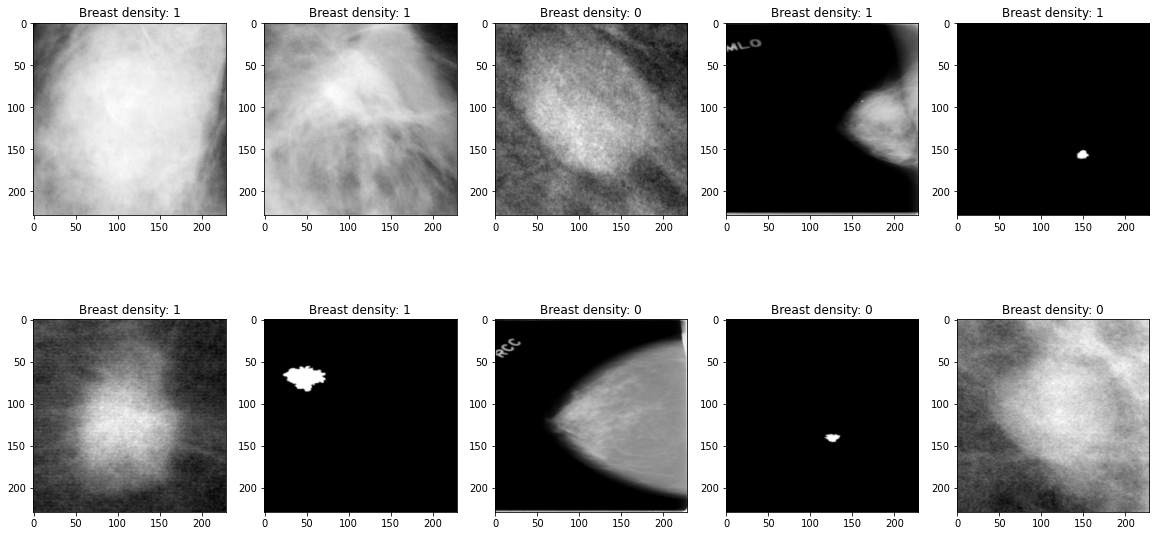

In [189]:
fig = plt.figure(figsize = (20,10))
r, c = 2, 5

data = [train_data, test_data]
labels = [train_labels, test_labels]

for i in range(10):
  select = np.random.randint(0,1)

  random_set = data[select]
  index = np.random.randint(1, len(random_set))
  random_image = random_set[index]
  label = labels[select][index]
  fig.add_subplot(r,c,i+1)

  plt.imshow(random_image, cmap='gray')
  plt.title("Breast density: " + str(label))
  #plt.show() # To view in column view

# Confusion Matrix & ROC Curve

***Problem Statement:*** Provide confusion matrix and ROC curve.

In [174]:
#data to work with
target_class = test_labels
predicted_class = rpreds


i) Confusion Matrix
---



**Resources:**


In [175]:
from sklearn.metrics import confusion_matrix

In [176]:
def conf_matrix(target_class, predicted_class):
  conf = confusion_matrix(target_class, predicted_class)
  plt.matshow(conf, cmap='binary')

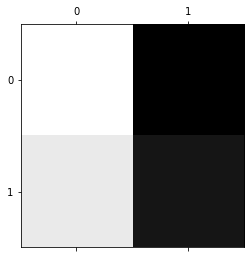

In [177]:
conf_matrix(target_class, predicted_class)


ii) ROC Curve
---



In [178]:
from sklearn.metrics import roc_curve, auc

In [179]:
def rocAnalyze(y_true, y_score):
  fpr, tpr, thresholds = roc_curve(y_true, y_score)

  print("False Positive Rate: ", fpr)
  print("True Positive Rate: ", tpr)
  print("Thresholds: ", thresholds)

  plt.plot(fpr, tpr)
  plt.title("ROC Curve")
  plt.xlabel("False Positive Rate")
  plt.ylabel("True Positive Rate")

  auc_ROC = auc(fpr, tpr)
  print("Area under curve: ", auc_ROC)
  return auc_ROC

False Positive Rate:  [0.         0.64285714 1.        ]
True Positive Rate:  [0.         0.61904762 1.        ]
Thresholds:  [2. 1. 0.]
Area under curve:  0.48809523809523814


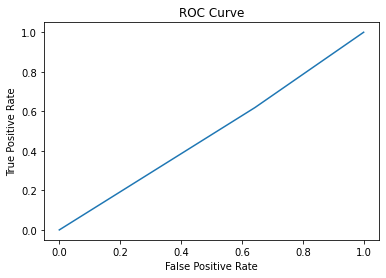

In [180]:
auc_ROC = rocAnalyze(target_class, predicted_class)

# DeLong Test & Confidence Interval

***Problem Statement:*** Perform DeLong test and confidence interval around the ROC curve using bootstrapping.

In [144]:
#data to work with
target_class = test_labels
predicted_class = rpreds

## i) DeLong Test

DeLong Test
Resources:

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

https://github.com/yandexdataschool/roc_comparison/blob/master/compare_auc_delong_xu.py

In [181]:
from scipy.stats import sem
from sklearn.metrics import roc_auc_score
import scipy.stats as st
from sklearn import metrics

In [182]:
#Modified from: https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

#bootstrapped_scores = []

def bootStrap(target_class, predicted_class, auc_ROC):
  print("Original ROC area: " + str(auc_ROC))

  n_bootstraps = 1000
  rng_seed = 42  # control reproducibility, 42
  bootstrapped_scores = []

  rng = np.random.RandomState(rng_seed)
  for i in range(n_bootstraps):
    # bootstrap by sampling with replacement on the prediction indices
    indices = rng.randint(0, len(predicted_class), len(predicted_class))
    if len(np.unique(target_class[indices])) < 2:
        # We need at least one positive and one negative sample for ROC AUC
        # to be defined: reject the sample
        continue
    score = roc_auc_score(target_class[indices], predicted_class[indices])
    bootstrapped_scores.append(score)
    #print("Bootstrap #" + str(i+1) + " ROC area: " + str('%.3f'%(score)))

  #print("Average Bootstrapped ROC area: " + str(sum(bootstrapped_scores)/len(bootstrapped_scores)))

  plt.hist(bootstrapped_scores, bins=50)
  plt.title('Histogram of the bootstrapped ROC AUC scores')
  plt.show()

Original ROC area: 0.48809523809523814


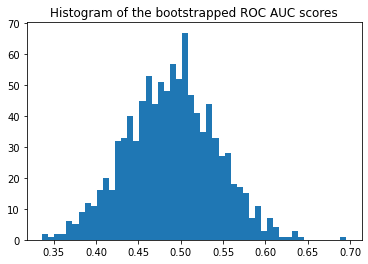

In [183]:
bootStrap(target_class, predicted_class, auc_ROC)

DeLong Test Code Source: https://biasedml.com/roc-comparison/

In [184]:
# credit: https://biasedml.com/roc-comparison/
def auc(X, Y):
    return 1/(len(X)*len(Y)) * sum([kernel(x, y) for x in X for y in Y])
def kernel(X, Y):
    return .5 if Y==X else int(Y < X)
def structural_components(X, Y):
    V10 = [1/len(Y) * sum([kernel(x, y) for y in Y]) for x in X]
    V01 = [1/len(X) * sum([kernel(x, y) for x in X]) for y in Y]
    return V10, V01
    
def get_S_entry(V_A, V_B, auc_A, auc_B):
    return 1/(len(V_A)-1) * sum([(a-auc_A)*(b-auc_B) for a,b in zip(V_A, V_B)])
def z_score(var_A, var_B, covar_AB, auc_A, auc_B):
    return (auc_A - auc_B)/((var_A + var_B - 2*covar_AB)**(.5))

In [185]:
random_preds = []
for _ in range(len(test_labels)):
  random_preds.append(np.random.randint(0,1))

random_preds = np.asarray(random_preds)

In [186]:
#credit: https://biasedml.com/roc-comparison/
def group_preds_by_label(preds, target_class):
    X = [p for (p, a) in zip(preds, target_class) if a]
    Y = [p for (p, a) in zip(preds, target_class) if not a]
    return X, Y

X_A, Y_A = group_preds_by_label(random_preds, target_class)
X_B, Y_B = group_preds_by_label(predicted_class, target_class)

V_A10, V_A01 = structural_components(X_A, Y_A)
V_B10, V_B01 = structural_components(X_B, Y_B)

auc_A = auc(X_A, Y_A)
auc_B = auc(X_B, Y_B)

# Compute entries of covariance matrix S (covar_AB = covar_BA)
var_A = (get_S_entry(V_A10, V_A10, auc_A, auc_A) * 1/len(V_A10)
         + get_S_entry(V_A01, V_A01, auc_A, auc_A) * 1/len(V_A01))

var_B = (get_S_entry(V_B10, V_B10, auc_B, auc_B) * 1/len(V_B10)
         + get_S_entry(V_B01, V_B01, auc_B, auc_B) * 1/len(V_B01))

covar_AB = (get_S_entry(V_A10, V_B10, auc_A, auc_B) * 1/len(V_A10)
            + get_S_entry(V_A01, V_B01, auc_A, auc_B) * 1/len(V_A01))

# Two tailed test
z = z_score(var_A, var_B, covar_AB, auc_A, auc_B)
p = st.norm.sf(abs(z))*2

print("z-score: " + str(z))
print("p-value: " + str(p))

z-score: 0.22347057672134518
p-value: 0.8231692804954005


## ii) Confidence Interval

***Resources:***

https://stackoverflow.com/questions/19124239/scikit-learn-roc-curve-with-confidence-intervals

In [187]:
def conf_interval():
  sorted_scores = np.array(bootstrapped_scores)
  sorted_scores.sort()

  #for 90% interval: low = 0.025, high = 0.975
  conf_low = '%.3f'%(sorted_scores[int(0.05 * len(sorted_scores))])
  conf_high = '%.3f'%(sorted_scores[int(0.95 * len(sorted_scores))])
  print("90% confidence interval: [" + str(conf_low) + " - " + str(conf_high) + "]")

In [188]:
conf_interval()

90% confidence interval: [0.500 - 0.500]
